## Raytracing for Computing the sky view factor
This notebook includes two implementation of SVF computing
1. The CPU based raytracing method to compute the SVF
2. The GPU PyCUDA based method to compute the SVF

This is based on my previous code for the paper published on Landscape and Urban Planning in 2017 at MIT and UCONN. Still using CPU

Last modified and cleaned on Jan 28, 2021 by Xiaojiang Li, Temple University

In [29]:
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import time
import math
import struct

# root = '../../data/Philadelphia'
# demfile = os.path.join(root, 'clipedDEM.tif')
# dsmfile = os.path.join(root, 'clipedDSM.tif')
# demfile = r'/drive2/researchProj/gpu-climate/spatial-data/26928E223414N_dsm.tif'
# demfile = '/drive2/researchProj/gpu-climate/spatial-data/clip_dsm2.tif'
# demfile = '/drive2/researchProj/gpu-climate/spatial-data/clip_phily.tif'
# demfile = '/drive2/researchProj/gpu-climate/spatial-data/ground_dsm/26981E233974N.tif'

dsmfile = demfile = r"E:\Code\gpusvf\gpusvf\test_data\BG_1F.tif"


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

gdal_dem = gdal.Open(demfile) #dem
dem = gdal_dem.ReadAsArray().astype(float)


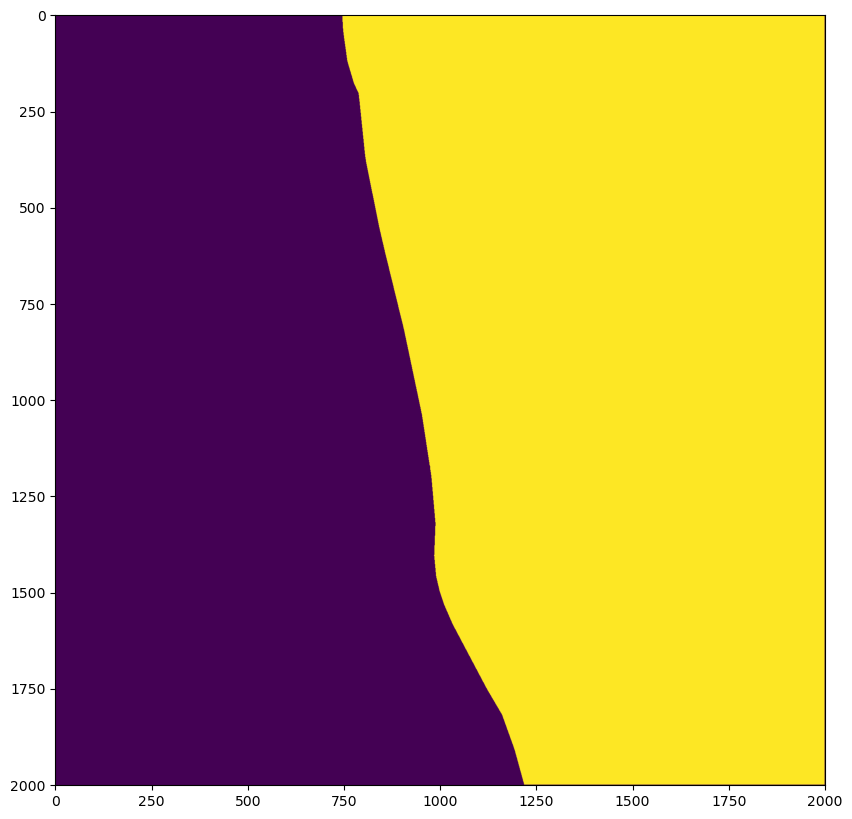

In [18]:

plt.figure(figsize=(10, 10))
plt.imshow(dem)
# plt.show()
plt.savefig('dem.png', dpi=300)


In [19]:

# def GetCentroidValue(fc,rast):
'''
This function is used to overlap the vector file on the raster file
and then compute the number of cols and rows in the raster file
First version July 5, 2016, After PK presentation, MIT Senseable City Lab

Make sure the two files have the same image projection, in this version,
no image transform id conducted, think about in future,

var source = new Proj4js.Proj('PROJ4_ARGS_FOR_YOUR_PROJECTION');
var dest = new Proj4js.Proj('EPSG:4326') // geographic coordinates + WGS84 (which matches the ellipsoid used in your .prj)

parameters:
    fc: the input feature class
    rast: the corresponding raster file
'''

# #open vector layer
# drv=ogr.GetDriverByName('ESRI Shapefile') #assuming shapefile?
# ds=drv.Open(fc,True) #open for editing
# lyr=ds.GetLayer(0)

# # add new field to store the calculated SVF result
# svfDem = ogr.FieldDefn('svfDEM1ft', ogr.OFTReal)
# lyr.CreateField(svfDem)


rast = demfile

#open raster layer
src_ds=gdal.Open(rast) 
gt=src_ds.GetGeoTransform()
rb=src_ds.GetRasterBand(1)
arrayDEM = rb.ReadAsArray()
gdal.UseExceptions() #so it doesn't print to screen everytime point is outside grid

# get the size of the raster
rows = arrayDEM.shape[0]
cols = arrayDEM.shape[1]
print ('The size rows is %s, the cols is %s :', rows,cols)


The size rows is %s, the cols is %s : 2001 2001


### Use raytracing to calculate the SVFfor some pixels(CPU version)

In [9]:
import time
import math


px = 120
py = 400


for px in range(100, 1000, 10):
    try: #in case raster isnt full extent
        structval=rb.ReadRaster(px,py,1,1,buf_type=gdal.GDT_Float32) #Assumes 32 bit int- 'float'
        intval = struct.unpack('f' , structval) #assume float
        val=intval[0]
    except:
        val=-9999 #or some value to indicate a fail
    
    t0 = time.time()
    
    ## CALCULATE SKY VIEW FACTOR FOR ALL GSV SITES
    SVF_res = 0
    
    # search all 360 angles for each pano site
    for thetaN in range(360):
        rangeDist = 200 # 500m
        #rangeFeet = int(rangeDist*3.28084)  # convert the meter to feet
        
        # create points along each angle
        radiusRange = range(5, rangeDist,1)
        theta = np.pi*thetaN/180
        
        # create an empty beta list to store the betas for each spike
        betaLst = []
        
        # create points along the ray line in 200m or 656 feet, one pixel is one foot
        for radius in radiusRange:
            rayX = int(px + radius*math.cos(theta))
            rayY = int(py + radius*math.sin(theta))
            
            # the corresponding building height is, consider the search region could out of the image
            if rayX >= cols or rayX < 0 or rayY >= rows or rayY < 0:
                continue
            
            # because the ground value is not zero, therefore, need to use the relative height
            buildH = arrayDEM[rayY,rayX] - arrayDEM[py, px]
            
            # if the pixel has its height lower than 2.5m, do not consider anymore
            #if buildH < 6.5:
            #    continue
            
            # considering the GSV pano is captured at height of 2.5m
            #beta = math.atan((buildH - 2.5)*3.28084/radius)
            beta = math.atan(buildH/radius)
            betaLst.append(beta)
        
        if len(betaLst)>0:
            maxBeta = max(betaLst)
        else:
            maxBeta = 0
        SVF_res = SVF_res + math.cos(maxBeta)**2
        
    SVF = SVF_res*1.0/360
    
    print('The svf and the time need is:', SVF, time.time() - t0)
    

The svf and the time need is: 1.0 0.09181070327758789
The svf and the time need is: 1.0 0.10040283203125
The svf and the time need is: 1.0 0.10033035278320312
The svf and the time need is: 1.0 0.09536480903625488
The svf and the time need is: 1.0 0.0951995849609375
The svf and the time need is: 1.0 0.09521842002868652
The svf and the time need is: 1.0 0.096710205078125
The svf and the time need is: 1.0 0.09758377075195312
The svf and the time need is: 1.0 0.09783935546875
The svf and the time need is: 1.0 0.0976095199584961
The svf and the time need is: 1.0 0.09757137298583984
The svf and the time need is: 1.0 0.09761929512023926
The svf and the time need is: 1.0 0.09757781028747559
The svf and the time need is: 1.0 0.0995931625366211
The svf and the time need is: 1.0 0.09595918655395508
The svf and the time need is: 1.0 0.09900116920471191
The svf and the time need is: 1.0 0.0995638370513916
The svf and the time need is: 1.0 0.0989995002746582
The svf and the time need is: 1.0 0.09793

KeyboardInterrupt: 

# Use Cupy instead of PyCUDA (Xuanyu's code)

In [30]:
# Block 1: 检测CuPy是否正确安装以及配置
import cupy as cp
import numpy as np

# 检查CUDA是否可用
print("CuPy version:", cp.__version__)
print("CUDA available:", cp.cuda.is_available())

if cp.cuda.is_available():
    # 显示GPU信息
    device = cp.cuda.Device()
    print("GPU device count:", cp.cuda.runtime.getDeviceCount())
    print("Current device:", device.id)
    print("Total memory:", device.mem_info[1] / (1024**3), "GB")
    print("Free memory:", device.mem_info[0] / (1024**3), "GB")
    
    # 简单测试
    a_cp = cp.array([1, 2, 3, 4, 5])
    b_cp = cp.array([6, 7, 8, 9, 10])
    c_cp = a_cp + b_cp
    print("CuPy test result:", c_cp)
    print("Test successful!")
else:
    print("CUDA is not available. Please check your CuPy installation.")

CuPy version: 13.6.0
CUDA available: True
GPU device count: 1
Current device: 0
Total memory: 11.99951171875 GB
Free memory: 10.71484375 GB
CuPy test result: [ 7  9 11 13 15]
Test successful!


In [31]:
# Block 2: GPU编码文件（CuPy内核）
import cupy as cp

# 定义CUDA内核
svf_kernel_code = r'''

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
#define PI 3.1415926f

extern "C" __global__ void svfcalculator(float* lattice_out, float* lattice, float scale, int imageW, int imageH) {
    int x = _X;
    int y = _Y;
    
    if (x >= imageW || y >= imageH) return;
    
    int index4 = _INDEX(x,y);
    float height0 = lattice[index4];
    
    if (height0 < 0) {
        lattice_out[index4] = 1.0;
        return;
    }
    
    float SVF_res = 0.0;
    
    // 360 degree checking
    for (int angle = 0; angle < 360; angle++) {
        float betaMax = 0.0;
        float alpha = angle * PI / 180.0;
        
        // For each angle, check different distances
        for (int dist = 1; dist < 200; dist++) {
            int x1 = x + dist * cos(alpha);
            int y1 = y + dist * sin(alpha);
            
            if (x1 < 0 || x1 >= imageW || y1 < 0 || y1 >= imageH) continue;
            
            int index2 = _INDEX(x1, y1);
            float height1 = lattice[index2];
            
            if (height1 < 0) continue;
            
            float beta = atan((height1 - height0) / (dist * scale));
            if (beta > betaMax) betaMax = beta;
        }
        
        SVF_res += cos(betaMax) * cos(betaMax);
    }
    
    lattice_out[index4] = SVF_res / 360.0;
}
'''

# 编译内核
svf_kernel = cp.RawKernel(svf_kernel_code, 'svfcalculator')

In [32]:
# Block 3: 剩下的其他部分
import time

def svfCalculator_RayTracingOnGPU(dsm, scale):
    '''This code is used to calculate the sky view factor using the ray-tracing
    algorithm based on the GPU acceleration
    last modified Jan 27, 2021
    by Xiaojiang Li, Temple University
    
    Parameters:
        dsm: the numpy array of the digital surface model
        scale: is the scale of the image, read from the gdal,
                1px of 2 feet, scale is 0.5; 1px of 3 feet, scale is 0.3333
    '''
    
    # 将输入数据转换为CuPy数组
    px = cp.asarray(dsm).astype(cp.float32)
    
    height, width = px.shape
    nb_pixels = height * width
    
    # 设置线程块和网格大小
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1

    tps1 = time.time()
    
    # 创建输出数组
    newLattice_gpu = cp.empty_like(px)
    
    # 调用内核
    svf_kernel(
        (nb_blocksY, nb_blocksX),  # grid
        (nb_ThreadsY, nb_ThreadsX),  # block
        (newLattice_gpu, px, cp.float32(scale), width, height)
    )
    
    # 等待GPU计算完成
    cp.cuda.Stream.null.synchronize()
    
    # 将结果复制回主机内存
    bwPx = cp.asnumpy(newLattice_gpu)
    
    return bwPx


In [33]:
# Block 4: 保存为GeoTIFF的函数
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    
    # close the datasets
    outBand = None
    outDs = None
    gdal_data = None

Processing image with shape: (2001, 2001)
The time elapsed is: 1.18 seconds
Saved result to E:\Code\gpusvf\gpusvf\test_data\svf_BG_1F.tif


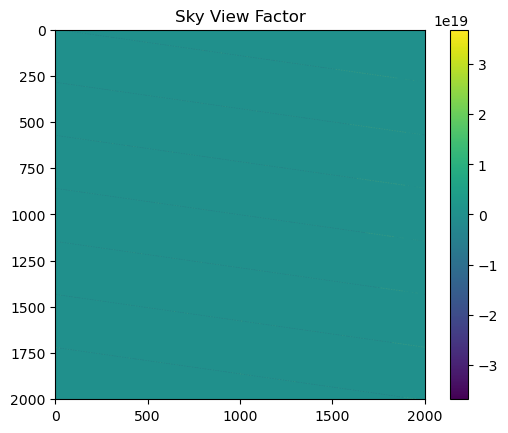

In [34]:
# Block 5: 主处理流程 (根据您的环境修改)
# 使用您已经加载的数据进行处理
t1 = time.time()

# 使用您已经读取的dsm数据
dsm_img = dsm  # 您已经通过 gdal_dsm.ReadAsArray().astype(float) 读取了数据

print(f"Processing image with shape: {dsm_img.shape}")

# 计算SVF
res = svfCalculator_RayTracingOnGPU(dsm_img, np.float32(scale))
t2 = time.time()
print(f'The time elapsed is: {t2-t1:.2f} seconds')

# 保存结果
output_filename = r"E:\Code\gpusvf\gpusvf\test_data\svf_BG_1F.tif"
saverasternd(gdal_dsm, output_filename, np.asarray(res))
print(f"Saved result to {output_filename}")

# 可视化结果
plt.imshow(np.asarray(res))
plt.colorbar()
plt.title("Sky View Factor")
plt.savefig(r"E:\Code\gpusvf\gpusvf\test_data\svf_BG_1F.png", dpi=300)
plt.show()

# 清理资源
gdal_dsm = None

### Using PyCUDA to accelerate the SVF calculation (Pycuda 1)

In [2]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.driver as cuda
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import time
import numpy as np                     # numeric python lib
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)      # setting default size of plots


print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)

1 device(s) found.
Device #0: GeForce GTX 1060 6GB
<module 'pycuda.driver' from '/home/jiang/anaconda3/envs/climategpu/lib/python3.7/site-packages/pycuda/driver.py'>


In [ ]:
 #Kernel text, Li iaojiang's Code
kernel = """

#include <math.h>

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
#define PI 3.1415926


//https://github.com/AlainPaillou/PyCuda_Denoise_Filters/blob/master/PyCuda_KNN_Denoise_Mono.py
__global__ void svfcalculator(float * lattice_out, float * lattice, float scale) //int w, int h
{
    #define NLM_BLOCK_RADIUS    3
    
    int rangeDist = 200;
    
    int imageW = 2000;
    int imageH = 2000;
    
    const long int   ix = blockDim.x * blockIdx.x + threadIdx.x;
    const long int   iy = blockDim.y * blockIdx.y + threadIdx.y;
    const float  x = (float)ix  + 1.0f;
    const float  y = (float)iy  + 1.0f;
    const float limxmin = -1;      //NLM_BLOCK_RADIUS + 2;
    const float limxmax = imageW; // - NLM_BLOCK_RADIUS - 2;
    const float limymin = -1;      //NLM_BLOCK_RADIUS + 2;
    const float limymax = imageH; // - NLM_BLOCK_RADIUS - 2;
    
    long int index4;    
    
    
    if(ix>limxmin && ix<limxmax && iy>limymin && iy<limymax){
        // sky view factor
        float SVF_res = 0;
        
        //Result accumulator
        float clr00 = 0.0;
        float clrIJ = 0.0;
        
        //Center of the KNN window
        index4 = x + (y * imageW);
        
        // the current pixel
        clr00 = lattice[index4];
        
        for(int thetaN =0; thetaN<360; thetaN++) 
        {
            float theta = PI*float(thetaN)/180;
            float betaMax = 0;
            
            for( float radius = 5; radius < rangeDist; radius = radius + 5)
            {   
                // this is important or you will have memory error
                if (x + int(radius*cos(theta)) > limxmax | x + int(radius*cos(theta)) < limxmin | y - int(radius*sin(theta)) > limymax | y - int(radius*sin(theta)) < 0) 
                {
                    break;
                }
            
                long int index2 = x + int(radius*cos(theta)) + (y - int(radius*sin(theta))) * imageW;
                clrIJ = lattice[index2];
                
                // building height information
                float buildH = clrIJ - clr00;
                
                float beta = atan(scale*buildH/radius); //because the pixel resolution is 2ft, height is in ft
                if (betaMax < beta)
                {
                    betaMax = beta;
                }
            }
            SVF_res += pow(cos(betaMax), 2);
        }
        
        lattice_out[index4] = SVF_res/360.0;
    }
    
}
"""


#Compile and get kernel function
mod = SourceModule(kernel)
print (mod)


In [ ]:
# Li Xiaojiang;s Code, based on pycuda
import PIL
from PIL import Image as PILImage
import rasterio as rio
import numpy
import pycuda.driver as drv


def svfCalculator_RayTracingOnGPU(dsm, scale):
    '''This code is used to calculate the sky view factor using the ray-tracing
    algorithm based on the GPU acceleration
    last modified Jan 27, 2021
    by Xiaojiang Li, Temple University
    
    Parameters:
        dsm: the numpy array of the digital surface model
        scale: is the scale of the image, read from the gdal,
                1px of 2 feet, scale is 0.5; 1px of 3 feet, scale is 0.3333
    '''
    
    px = numpy.array(dsm).astype(numpy.float32)
    
    #print ('Size:' + str(dsm.shape))
    #print ('Pixels:' + str (dsm.shape[0]*dsm.shape[1]))
    #print('The px.nbtyle is:', px.nbytes, px.shape)
    
    
    # allocate memory on the device and transfer data to GPU 
    d_px = cuda.mem_alloc(px.nbytes)
    cuda.memcpy_htod(d_px, px)
    
    height,width = px.shape
    nb_pixels = height * width
    
    # Set blocks et Grid sizes
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1

    #print("Test GPU ",nb_blocksX*nb_blocksY," Blocks ",nb_ThreadsX*nb_ThreadsY," Threads/Block")
    tps1 = time.time()
    
    
    # create empty array
    lattice_gpu = gpuarray.to_gpu(px)
    newLattice_gpu = gpuarray.empty_like(lattice_gpu)
    
    # the GPU function
    KNN_Mono_GPU = mod.get_function("svfcalculator")
    KNN_Mono_GPU(newLattice_gpu, d_px, np.float32(scale), \
               block=(nb_ThreadsX,nb_ThreadsY,1), \
               grid=(nb_blocksX,nb_blocksY))  
    
    bwPx = numpy.empty_like(px)    
    bwPx = newLattice_gpu.get()
    
    bwPx = numpy.float32(bwPx)
    #pil_im = PILImage.fromarray(bwPx)
    
    return bwPx
    

### Save the numpy as a geotiff (Pycuda 2)

In [5]:
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    

### Compute SVFs and save the results (Pycuda 3)

In [6]:
import os, os.path
import gdal
from osgeo.gdalconst import *
import time

root = r'/drive2/thermal-env/data/miami/ground_dsm'
outroot = r'/drive2/thermal-env/data/miami/svf'
if not os.path.exists(outroot):
    os.mkdir(outroot)


for file in os.listdir(root):
    filename = os.path.join(root, file)
    t0 = time.time()
    
    ### using rasterio to read the raster dsm
    #dsm_dataset = rio.open(filename)
    #dsm_img = dsm_dataset.read(1)
    
    ### using gdal to read the raster dsm
    gdal_dsm = gdal.Open(filename)
    dsm_img = gdal_dsm.ReadAsArray().astype(np.float)#dsm
    geotransform = gdal_dsm.GetGeoTransform()
    scale = 1 / geotransform[1]
    
    ## calculate the svf
    svfres = svfCalculator_RayTracingOnGPU(dsm_img, scale)
    print('The time and file are:', time.time() - t0, filename)
    
    outsvfname = os.path.join(outroot, 'svf_' + file)
    saverasternd(gdal_dsm, outsvfname, np.asarray(svfres))
    

The time and file are: 3.802354574203491 /drive2/thermal-env/data/miami/ground_dsm/row5-col7.tif
The time and file are: 3.4475760459899902 /drive2/thermal-env/data/miami/ground_dsm/row1-col6.tif
The time and file are: 3.5248067378997803 /drive2/thermal-env/data/miami/ground_dsm/row1-col7.tif
The time and file are: 4.1054487228393555 /drive2/thermal-env/data/miami/ground_dsm/row1-col8.tif
The time and file are: 3.4862232208251953 /drive2/thermal-env/data/miami/ground_dsm/row2-col4.tif
The time and file are: 3.4590840339660645 /drive2/thermal-env/data/miami/ground_dsm/row2-col5.tif
The time and file are: 3.4673335552215576 /drive2/thermal-env/data/miami/ground_dsm/row2-col6.tif
The time and file are: 3.515775442123413 /drive2/thermal-env/data/miami/ground_dsm/row2-col7.tif
The time and file are: 3.4630892276763916 /drive2/thermal-env/data/miami/ground_dsm/row3-col3.tif
The time and file are: 3.4762158393859863 /drive2/thermal-env/data/miami/ground_dsm/row3-col4.tif
The time and file are:

In [7]:
import time

# demfile = r'/drive2/researchProj/gpu-climate/spatial-data/ground_dsm/26981E233974N.tif'
# demfile = r'/drive2/researchProj/gpu-climate/spatial-data/26928E223414N_dsm.tif'
demfile = r'/drive2/thermal-env/data/miami/ground_dsm/row5-col7.tif'

t1 = time.time()

dem_dataset = rio.open(demfile)
dsm_img = dem_dataset.read(1)


res = svfCalculator_RayTracingOnGPU(dsm_img, np.float32(scale))
t2 = time.time()
print('The time elapsed is:', t2-t1)


The time elapsed is: 3.8653388023376465


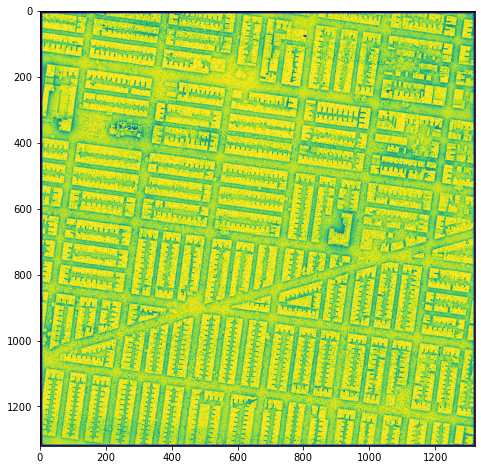

In [19]:
# saverasternd(gdal_dsm, 'svfNfile-dem-gpu.tif', np.asarray(res))

# stopTimer()
plt.imshow(np.asarray(res))
saverasternd(gdal_dsm, 'outsvfname.tif', np.asarray(res))
plt.savefig('svf.png', dpi=300)

In [18]:
import gdal
from osgeo.gdalconst import *

gdal_dsm = gdal.Open(demfile)
dsm = gdal_dsm.ReadAsArray().astype(np.float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]
